In [45]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import json
from matplotlib import pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import scipy.stats as scs
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import seaborn as sns
import lightgbm as lgb
import itertools
from pylab import rcParams

1. Прочитайте базу my_BRENT2019.csv и перейдите к представлению ряда первыми разностями

In [2]:
df = pd.read_csv('my_BRENT2019.csv',sep = ',', index_col=[0], parse_dates=[0])

In [33]:
df.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


In [106]:
df2 = df.iloc[:-1]

In [107]:
df2['brent_first_diff'] = df['Значение'].values[1:]- df['Значение'].values[:-1]

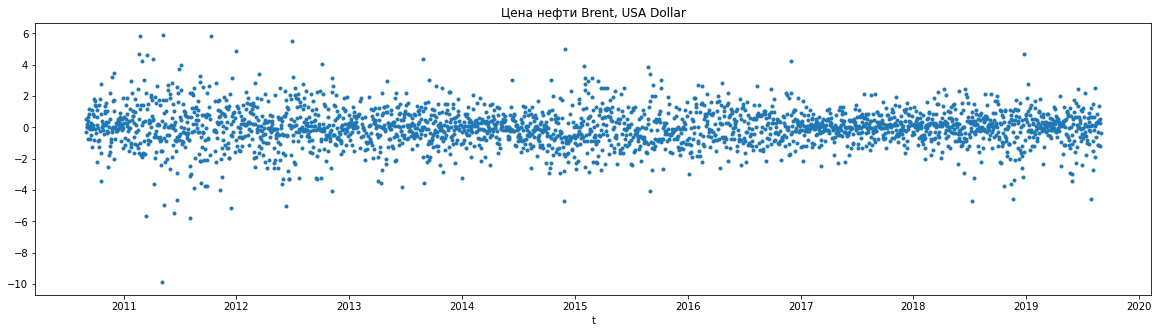

In [103]:
plt.figure(figsize=(20,5))
plt.plot(df2.index, df2['brent_first_diff'], '.')
plt.xlabel('t')
plt.title('Цена нефти Brent, USA Dollar')
plt.show()

In [28]:
display(df.index[0])
display(df.index[-1])

Timestamp('2010-09-01 00:00:00')

Timestamp('2019-09-01 00:00:00')

2. Добавьте первые разности по стоимости доллара и евро к рублю

In [86]:
with open('dollar.json') as json_file:
    data = json.load(json_file)

In [87]:
df_dollar = pd.DataFrame(data)

In [88]:
df_dollar['date'] =  pd.to_datetime(df_dollar['date'], format='%Y-%m-%d')
df_dollar = df_dollar.set_index('date')

In [89]:
df_dollar.head()

,value
date,
1997-01-06,5570.0
1997-01-07,5573.0
1997-01-09,5580.0
1997-01-10,5585.0
1997-01-11,5590.0


In [90]:
df_dollar.shape

(8566, 1)

In [91]:
with open('euro.json') as json_file:
    data = json.load(json_file)

In [92]:
df_euro = pd.DataFrame(data)
df_euro['date'] =  pd.to_datetime(df_euro['date'], format='%Y-%m-%d')
df_euro = df_euro.set_index('date')

In [93]:
df_euro.head()

,value
date,
1999-01-06,24.40
1999-01-07,25.73
1999-01-08,25.73
1999-01-09,25.73
1999-01-10,25.73


In [94]:
df_euro.shape

(7843, 1)

In [105]:
df_1 = df.join(df_dollar).rename(columns={"value": "usd"})
df_2 = df_1.join(df_euro).rename(columns={"value": "euro"})
df_2.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,usd,euro
Дата,,,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0,30.8669,39.0127
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0,30.8001,39.1654
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0,30.6858,39.2901
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0,30.6922,39.3505
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0,30.6922,39.3505


In [108]:
df2['usd_first_diff'] = df_2['usd'].values[1:]- df_2['usd'].values[:-1]
df2['euro_first_diff'] = df_2['euro'].values[1:]- df_2['euro'].values[:-1]

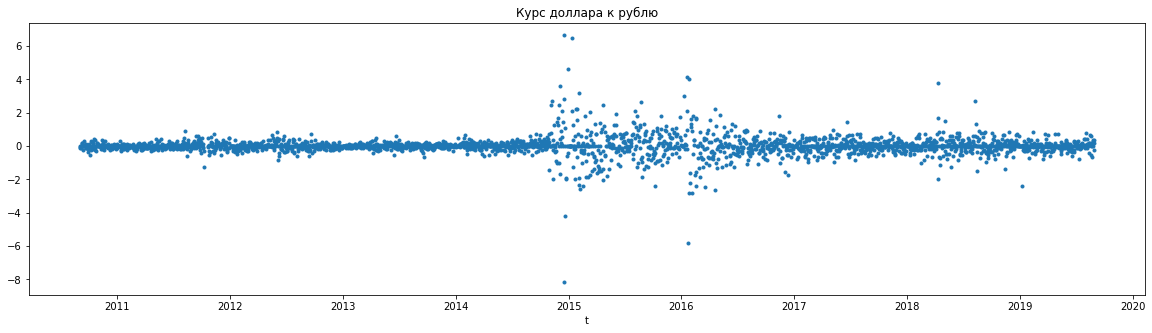

In [109]:
plt.figure(figsize=(20,5))
plt.plot(df2.index, df2['usd_first_diff'],'.')
plt.xlabel('t')
plt.title('Курс доллара к рублю')
plt.show()

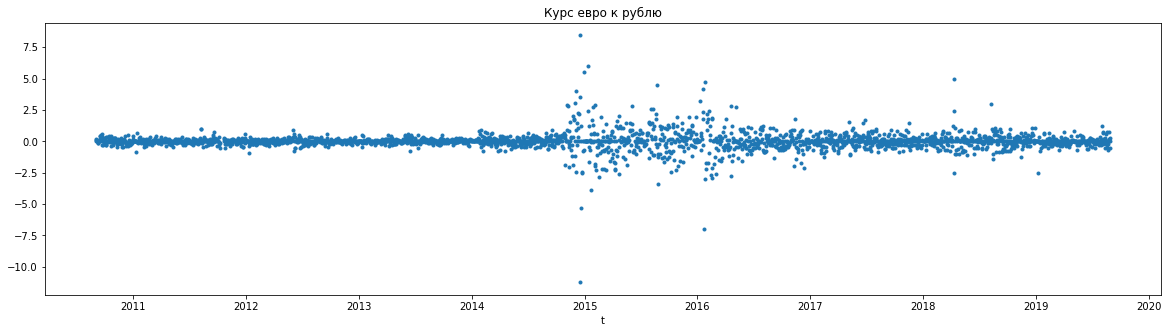

In [110]:
plt.figure(figsize=(20,5))
plt.plot(df2.index, df2['euro_first_diff'],'.')
plt.xlabel('t')
plt.title('Курс евро к рублю')
plt.show()

In [111]:
df2.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,brent_first_diff,usd_first_diff,euro_first_diff
Дата,,,,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0,0.52,-0.0668,0.1527
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0,-0.32,-0.1143,0.1247
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0,0.05,0.0064,0.0604
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0,0.01,0.0000,0.0000
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0,0.24,0.0000,0.0000


3. сделайте ее перрасчет (ресемплинг) в представление по неделям. 

In [144]:
df2_w = df2.resample('W').mean()
df2_w.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,brent_first_diff,usd_first_diff,euro_first_diff
Дата,,,,,,,,,,,,,,
2010-09-05,76.616000,2010.0,9.000000,3.000000,3.000000,246.000000,35.0,4.000000,0.000000,0.2,0.000000,0.100000,-0.034940,0.067560
2010-09-12,77.673333,2010.0,9.000000,8.500000,3.000000,251.500000,36.0,2.500000,0.166667,0.0,0.166667,0.386667,0.033583,-0.026467
2010-09-19,78.693333,2010.0,9.000000,15.666667,3.000000,258.666667,37.0,2.666667,0.000000,0.0,0.000000,0.028333,0.031483,0.269967
2010-09-26,78.518333,2010.0,9.000000,22.666667,3.000000,265.666667,38.0,2.666667,0.000000,0.0,0.000000,-0.203333,-0.022433,0.074733
2010-10-03,81.211667,2010.0,9.333333,19.666667,3.333333,272.666667,39.0,2.666667,0.000000,0.0,0.000000,0.860000,-0.073100,0.066783


4. Постройте модель предсказания 1-й точки от текущей (h=1).

In [145]:
#уберем лишние признаки:
df2_w.drop(['Значение', 'dayofmonth', 'dayofweek'], axis=1, inplace=True)

In [146]:
#найдем пустые значения
df2_w.loc[df2_w['brent_first_diff'].isnull()]

,year,month,quarter,dayofyear,weekofyear,is_holiday,is_prev_holiday,is_next_holiday,brent_first_diff,usd_first_diff,euro_first_diff
Дата,,,,,,,,,,,
2011-10-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Уберем пустые значения, т.к. это всего 1 день

In [147]:
df2_w = df2_w.dropna(axis=0)

Построим кластеризационный признак

In [148]:
scl=StandardScaler()
tsne_ =TSNE(n_components=2)

X = df2_w.iloc[:,:-1].values

Xscale = scl.fit_transform(X)
X_t = tsne_.fit_transform(Xscale)

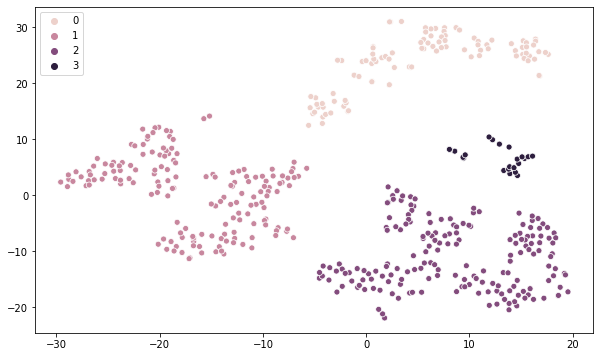

In [149]:
rcParams['figure.figsize'] = 10, 6
clast_0 = DBSCAN(eps=5, leaf_size=15 )
clast_1 = DBSCAN(eps=2, leaf_size=5)
X_clast =clast_0.fit_predict(X_t)
X_scale_clast =clast_1.fit_predict(Xscale)

sns.scatterplot(X_t[:,0],X_t[:,1], hue=X_clast)
plt.show()

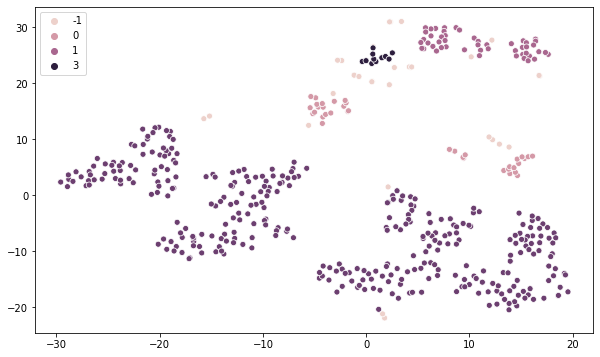

In [150]:
sns.scatterplot(X_t[:,0],X_t[:,1], hue=X_scale_clast )
plt.show()

In [152]:
print('Число кластеров с масштабированием: ',len(np.unique(X_scale_clast)))
print('Число кластеров без масштабирования: ',len(np.unique(X_clast)))

Число кластеров с масштабированием:  5
Число кластеров без масштабирования:  4


Добавим обе кластеризации в признаки

In [153]:
df2_w['X_clast'] = X_clast
df2_w['X_scale_clast'] = X_scale_clast

Добавим признаки на основе компонетного анализа

In [154]:
pca = PCA(n_components=2, svd_solver='full')
Xpca = pca.fit_transform(Xscale[:,1:])
Xpca.shape

(469, 2)

In [155]:
df2_w['pca1']=Xpca[:,0]
df2_w['pca2']=Xpca[:,1]

Добавим скользящее среднее с глубиной 4 недели

In [157]:
df2_w['d_w4'] = df2_w['brent_first_diff'].rolling(window=4).mean()

и экспонентциальную среднюю

In [158]:
def exponential_smoothing(series, alpha):
    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [160]:
df2_w['exp_0_01'] = exponential_smoothing(df2_w['brent_first_diff'], 0.01)
df2_w['exp_0_03'] = exponential_smoothing(df2_w['brent_first_diff'], 0.03)
df2_w['exp_0_04'] = exponential_smoothing(df2_w['brent_first_diff'], 0.04)
df2_w['exp_0_05'] = exponential_smoothing(df2_w['brent_first_diff'], 0.05)
df2_w['exp_0_06'] = exponential_smoothing(df2_w['brent_first_diff'], 0.06)
df2_w['exp_0_07'] = exponential_smoothing(df2_w['brent_first_diff'], 0.07)
df2_w['exp_0_08'] = exponential_smoothing(df2_w['brent_first_diff'], 0.08)

In [161]:
p = 12
for i in range(p):
    df2_w['t'+str(p-i)]=0
    df2_w['t'+str(p-i)].values[p:] = df2_w['brent_first_diff'].values[i:-(p)+i]

Выделим существенные признаки

In [188]:
scl_target=StandardScaler() 
h=1
target = df2_w['brent_first_diff'].values[h+p:].reshape((df2_w.shape[0]-h-p,1))
y = scl_target.fit_transform(target)
y.shape

(456, 1)

In [189]:
scl_x=StandardScaler() 

X = df2_w.iloc[p:-h,:].values
X = scl_x.fit_transform(X.astype('float64'))
X.shape

(456, 35)

Применим автоматизацию выбора через SelectKBest c выделением 15 лучших признаков.

In [197]:
sfk = SelectKBest(f_regression, k=15)
X_new = sfk.fit_transform(X, y.ravel())
X_new.shape

(456, 15)

In [198]:
column_names = df2_w.columns[sfk.get_support()]
column_names

Index(['month', 'quarter', 'dayofyear', 'weekofyear', 'is_prev_holiday',
       'brent_first_diff', 'usd_first_diff', 'euro_first_diff', 'pca1', 'd_w4',
       't12', 't8', 't6', 't3', 't2'],
      dtype='object')

Разделим данные на тестовые и тренировочные

In [199]:
# сделаем функцию разделения на тестовые и тренировочные
def split_data(data, split_date ):
    return data.loc[data.index.get_level_values('Дата') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Дата') >  split_date].copy()

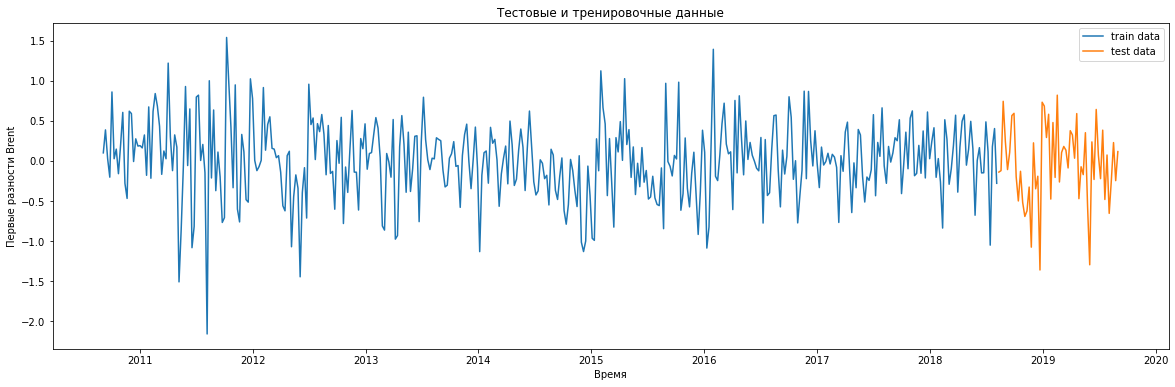

In [200]:
rcParams['figure.figsize'] = 20, 6
train, test = split_data(df2_w, '2018-08-05')

plt.xlabel('Время')
plt.ylabel('Первые разности Brent')
plt.plot(train.index.get_level_values('Дата'),train['brent_first_diff'], label='train data' )
plt.plot(test.index.get_level_values('Дата'),test['brent_first_diff'], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [201]:
X_train = X_new[:train.shape[0],:]
y_train = y[:train.shape[0],0]
X_test = X_new[train.shape[0]:,:]
y_test = y[train.shape[0]:,0]
train.shape

(413, 35)

Построим модель

In [204]:
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [202]:
param_dist = {"max_depth": [3,2,10,14,5], 
              "n_estimators":[100,200,300,400,500,1000]}

#  randomized search
n_iter_search = 10

In [205]:
%%time
model_gr = GradientBoostingRegressor()

random_search = RandomizedSearchCV(model_gr, param_distributions=param_dist, cv=5, iid=False)

random_search.fit(X_train, y_train)

report(random_search.cv_results_)

Model with rank: 1
Mean validation score: -0.257 (std: 0.122)
Parameters: {'n_estimators': 200, 'max_depth': 2}

Model with rank: 2
Mean validation score: -0.263 (std: 0.133)
Parameters: {'n_estimators': 100, 'max_depth': 3}

Model with rank: 3
Mean validation score: -0.306 (std: 0.162)
Parameters: {'n_estimators': 100, 'max_depth': 5}

Model with rank: 4
Mean validation score: -0.355 (std: 0.233)
Parameters: {'n_estimators': 500, 'max_depth': 5}

Model with rank: 5
Mean validation score: -0.411 (std: 0.236)
Parameters: {'n_estimators': 400, 'max_depth': 10}

Wall time: 19.4 s


In [206]:
model_g = GradientBoostingRegressor(max_depth=2, random_state=0, n_estimators=200)

In [207]:
model_g.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=0)

In [208]:
y_test_pred_g = model_g.predict(X_test)

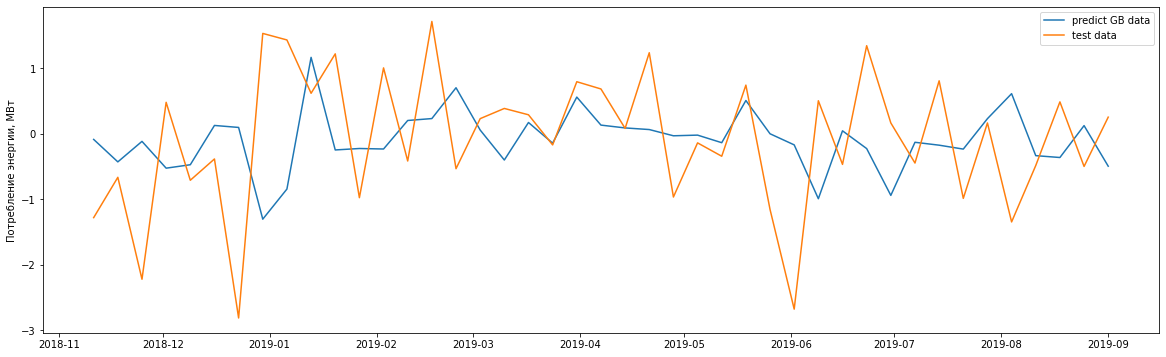

In [209]:
## plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[h+p:],y_test_pred_g, label='predict GB data' )
plt.plot(test.index[h+p:],y_test, label='test data')

plt.legend()
plt.show()

In [210]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [211]:
#Посмотрим на метрики качества
er_s = mean_squared_error(y_true=y_test, y_pred=y_test_pred_g) 
er_a = mean_absolute_error(y_true=y_test, y_pred=y_test_pred_g) 
er_r2 = r2_score(y_true=y_test, y_pred=y_test_pred_g)
er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test), 
                                      y_pred = scl_target.inverse_transform( y_test_pred_g))

print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка mse :   1.443939835842348 
ошибка mae  :   0.9316225585640483 
оценка R2 :   -0.3184301272309935
ошибка градиентного бустинга MAPE :   123.10180909445292 %


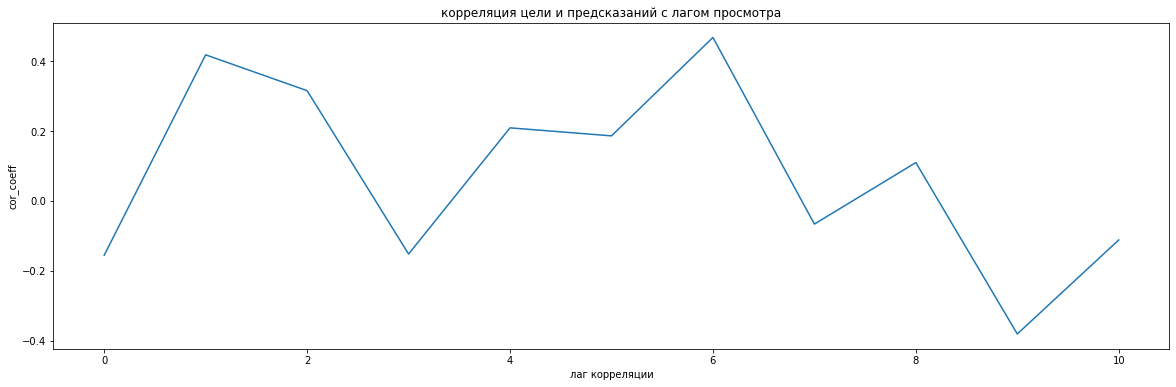

In [212]:
lag=10
p_cor=[np.corrcoef( y_test, y_test_pred_g)[1,0]]
for i in range(lag):
    c=np.corrcoef( y_test[:-(i+1)], y_test_pred_g[(i+1):])[1,0]
    p_cor.append(c)    

plt.plot(np.array(p_cor) )  
plt.xlabel('лаг корреляции')
plt.ylabel('cor_coeff')
plt.title('корреляция цели и предсказаний с лагом просмотра')
plt.show()

5. Сделайте вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием.

Градиентный бустинг дал катастрофически плохой результат